<a href="https://colab.research.google.com/github/feliinabucket/Machine_Learning_Group07/blob/main/ML_Ex1_Classification_logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data collection, import modules, setup

In [ ]:
## Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')  # This may also be needed for WordNet lemmatizer

nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Dataset- sentiment Analysis for Financial use

In [ ]:
file_path = '/content/drive/MyDrive/Financial_Sentiment_Analysis/all-data.csv'

df = pd.read_csv(file_path,encoding='ISO-8859-1',header=None, names=['class','text'])
df.head()


,class,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


### Data cleaning/preprocessing

In [ ]:
df.shape

(4846, 2)

In [ ]:

# Count the occurrences of each sentiment class
sentiment_counts = df['class'].value_counts()

# Calculate the percentage of positive and negative classes
positive_percentage = (sentiment_counts['positive'] / len(df)) * 100
neutral_percentage = (sentiment_counts['neutral'] / len(df)) * 100
negative_percentage = (sentiment_counts['negative'] / len(df)) * 100

# Print the percentages
print("Positive Percentage:", positive_percentage)
print("Neutral Percentage:", neutral_percentage)
print("Negative Percentage:", negative_percentage)

Positive Percentage: 28.126289723483282
Neutral Percentage: 59.40982253404869
Negative Percentage: 12.463887742468014


In [ ]:
#print the number of null values in each column
df.isnull().sum()

,0
class,0
text,0


#### Text pre processing

In [ ]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['preprocessed_text'] = df['text'].apply(preprocess_text)


#### Feature extraction


In [ ]:


tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['preprocessed_text']).toarray()
y = df['class']


#### Train test split

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
print(y_train)

132     positive
1189     neutral
798     positive
2000    positive
3488     neutral
          ...   
1840     neutral
1129    positive
1682     neutral
1016     neutral
3477     neutral
Name: class, Length: 3876, dtype: object


###Model Training


In [ ]:
# Logistic Regression Model
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000,multi_class='ovr')
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression with TF-IDF:")
print(classification_report(y_test, y_pred_log_reg))

# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes with TF-IDF:")
print(classification_report(y_test, y_pred_nb))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression with TF-IDF:
              precision    recall  f1-score   support

    negative       0.55      0.64      0.59       121
     neutral       0.79      0.81      0.80       576
    positive       0.63      0.55      0.58       273

    accuracy                           0.71       970
   macro avg       0.65      0.66      0.66       970
weighted avg       0.71      0.71      0.71       970

Naive Bayes with TF-IDF:
              precision    recall  f1-score   support

    negative       1.00      0.07      0.14       121
     neutral       0.71      0.96      0.81       576
    positive       0.62      0.40      0.49       273

    accuracy                           0.69       970
   macro avg       0.78      0.48      0.48       970
weighted avg       0.72      0.69      0.64       970



In [ ]:
# Initialize and train the Random Forest classifier with class weights
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
print("Random Forest with TF-IDF:")
print(classification_report(y_test, y_pred_rf))





Random Forest with TF-IDF:
              precision    recall  f1-score   support

    negative       0.74      0.41      0.53       121
     neutral       0.74      0.94      0.83       576
    positive       0.72      0.44      0.55       273

    accuracy                           0.74       970
   macro avg       0.73      0.60      0.63       970
weighted avg       0.73      0.74      0.71       970



#### Applying Over-sampling techniques to minority classes

In [ ]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


log_reg = LogisticRegression(class_weight='balanced', max_iter=1000,multi_class='ovr')
log_reg.fit(X_train_resampled, y_train_resampled)

y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression after SMOTE:")
print(classification_report(y_test, y_pred_log_reg))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression after SMOTE:
              precision    recall  f1-score   support

    negative       0.55      0.64      0.59       121
     neutral       0.79      0.82      0.80       576
    positive       0.64      0.55      0.59       273

    accuracy                           0.72       970
   macro avg       0.66      0.67      0.66       970
weighted avg       0.72      0.72      0.72       970



#### Hyper parameter tuning

In [ ]:
from imblearn.pipeline import Pipeline  # Use imblearn's Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define the parameter grid for Logistic Regression
param_grid = {
    'log_reg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'log_reg__C': [0.01, 0.1, 1, 10, 100],
    'log_reg__solver': ['lbfgs', 'saga'],
    'log_reg__max_iter': [100, 500, 1000]
}

# Create a pipeline for SMOTE and Logistic Regression
pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('log_reg', LogisticRegression(class_weight='balanced', random_state=42, multi_class='ovr'))
])

# Set up GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1_macro',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and evaluate on the test set
print("Best Parameters:", grid_search.best_params_)

# Predict using the best estimator
y_pred_best = grid_search.best_estimator_.predict(X_test)

# Evaluate the model
print("Classification Report for Best Model:")
print(classification_report(y_test, y_pred_best))


Fitting 5 folds for each of 120 candidates, totalling 600 fits


#Dataset for Voting Congressional data


In [61]:
train_path = '/content/drive/MyDrive/congressional-voting/CongressionalVotingID.shuf.lrn.csv'
test_path = '/content/drive/MyDrive/congressional-voting/CongressionalVotingID.shuf.tes.csv'
sol_path =  '/content/drive/MyDrive/congressional-voting/CongressionalVotingID.shuf.sol.ex.csv'

# Load datasets
train_df = pd.read_csv(train_path, encoding='ISO-8859-1')
test_df = pd.read_csv(test_path, encoding='ISO-8859-1')
sol_df = pd.read_csv(sol_path, encoding='ISO-8859-1')

# Display the first few rows
train_df.head()


,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,362,democrat,y,n,y,n,y,y,y,n,y,y,n,n,y,y,n,unknown
1,86,democrat,n,n,y,n,y,y,n,n,n,y,y,y,y,y,n,y
2,264,democrat,y,n,y,n,n,n,y,y,y,n,n,n,n,n,y,unknown
3,258,republican,n,n,n,y,y,n,n,n,n,n,n,y,n,y,unknown,y
4,381,democrat,y,y,y,n,n,y,unknown,y,y,n,y,n,y,n,y,y


### Data cleaning/preprocessing

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report


In [62]:
# Merge test_df and sol_df based on the ID column to get the 'class' column
test_df = test_df.merge(sol_df, on="ID")

# Reorder columns to place 'class' right after 'ID'
columns = ['ID', 'class'] + [col for col in test_df.columns if col not in ['ID', 'class']]
test_df = test_df[columns]

# Display the result
test_df.head()


,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,190,democrat,y,n,y,n,n,n,y,y,y,n,n,n,n,n,y,y
1,285,democrat,n,n,y,n,n,y,y,y,y,y,y,n,n,n,unknown,y
2,251,democrat,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,n
3,40,democrat,y,n,y,n,n,n,y,y,y,y,y,n,y,n,y,y
4,91,democrat,y,n,y,n,n,n,y,y,y,y,n,n,n,n,y,y


####encode categorical variables and handle missing values

In [63]:

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Separate features and target
X_train = train_df.drop(['ID', 'class'], axis=1)
y_train = train_df['class']
X_test = test_df.drop(['ID', 'class'], axis=1)
y_test = test_df['class']


# Handle categorical features (if any)
if X_train.select_dtypes(include=['object']).shape[1] > 0:
    encoder = OneHotEncoder(drop='first', sparse_output=False)  # One-hot encoding
    X_train = pd.DataFrame(encoder.fit_transform(X_train), index=X_train.index)
    X_test = pd.DataFrame(encoder.transform(X_test), index=X_test.index)

# Ensure target variable is numeric
if y_train.dtype == 'object':
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

# Replace any NaN values in features with -1 (if necessary)
X_train.fillna(-1, inplace=True)
X_test.fillna(-1, inplace=True)

In [64]:

# Initialize the Logistic Regression model
clf = LogisticRegression(random_state=42, max_iter=1000)  # Increase max_iter if necessary

# Train the Logistic Regression model
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [65]:
test_df.head()

,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,190,democrat,y,n,y,n,n,n,y,y,y,n,n,n,n,n,y,y
1,285,democrat,n,n,y,n,n,y,y,y,y,y,y,n,n,n,unknown,y
2,251,democrat,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,n
3,40,democrat,y,n,y,n,n,n,y,y,y,y,y,n,y,n,y,y
4,91,democrat,y,n,y,n,n,n,y,y,y,y,n,n,n,n,y,y


In [66]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


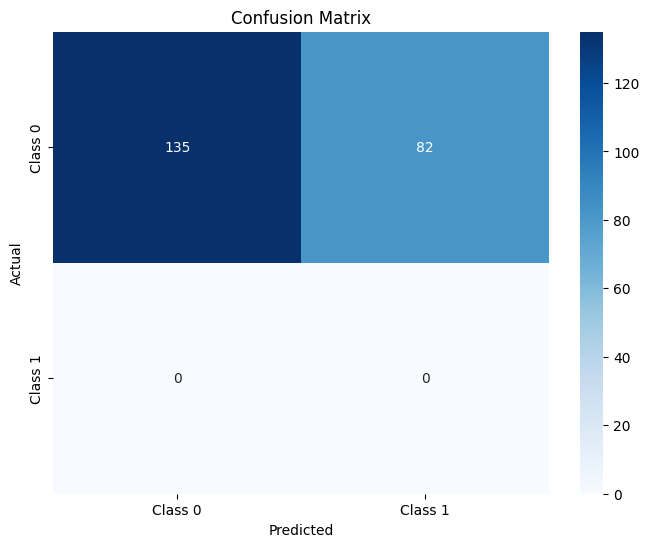


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       217
           1       0.00      0.00      0.00         0

    accuracy                           0.62       217
   macro avg       0.50      0.31      0.38       217
weighted avg       1.00      0.62      0.77       217


Accuracy Score:
0.6221198156682027


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print Accuracy Score
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


####hyper parameter tuning

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
375 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/


Best Parameters from GridSearchCV:
{'C': 10, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}

Best Accuracy Score from GridSearchCV:
0.967970401691332


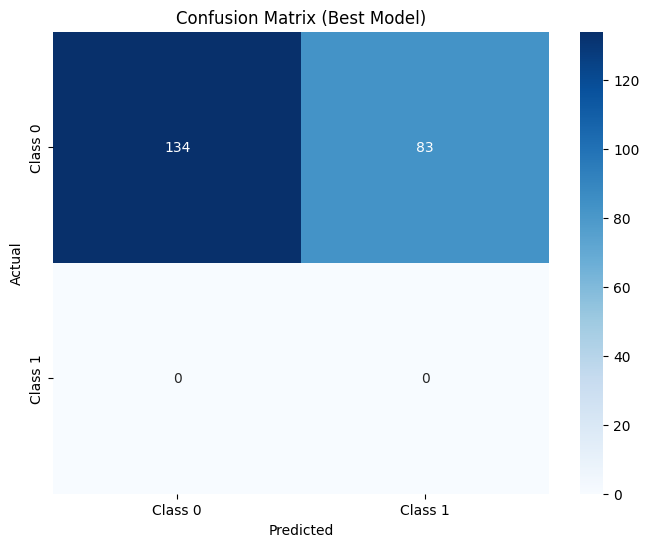


Classification Report (Best Model):
              precision    recall  f1-score   support

           0       1.00      0.62      0.76       217
           1       0.00      0.00      0.00         0

    accuracy                           0.62       217
   macro avg       0.50      0.31      0.38       217
weighted avg       1.00      0.62      0.76       217


Accuracy Score (Best Model):
0.6175115207373272


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Regularization type
    'C': [0.01, 0.1, 1, 10, 100],               # Inverse of regularization strength
    'solver': ['lbfgs', 'liblinear', 'saga'],   # Solver type
    'max_iter': [100, 500, 1000]                # Maximum number of iterations
}

# Initialize Logistic Regression
log_reg = LogisticRegression(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("\nBest Parameters from GridSearchCV:")
print(grid_search.best_params_)

print("\nBest Accuracy Score from GridSearchCV:")
print(grid_search.best_score_)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the best model
cm = confusion_matrix(y_test, y_pred)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print Classification Report
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred))

# Print Accuracy Score
print("\nAccuracy Score (Best Model):")
print(accuracy_score(y_test, y_pred))


#Reviews dataset

In [ ]:
train_path = '/content/drive/MyDrive/reviews/amazon_review_ID.shuf.lrn.csv'
test_path = '/content/drive/MyDrive/reviews/amazon_review_ID.shuf.tes.csv'
sol_path =  '/content/drive/MyDrive/reviews/amazon_review_ID.shuf.sol.ex.csv'

# Load datasets
train_df = pd.read_csv(train_path, encoding='ISO-8859-1')
test_df = pd.read_csv(test_path, encoding='ISO-8859-1')
sol_df = pd.read_csv(sol_path, encoding='ISO-8859-1')

# Display the first few rows
train_df.head()




,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V9992,V9993,V9994,V9995,V9996,V9997,V9998,V9999,V10000,Class
0,0,17,4,8,8,9,4,0,2,3,...,0,0,0,0,0,0,0,1,1,Shea
1,1,21,9,5,8,6,2,16,3,12,...,0,0,0,2,2,1,0,1,0,Riley
2,2,9,7,6,3,8,2,9,4,4,...,0,0,0,0,0,0,0,1,1,Chachra
3,3,8,3,5,2,4,3,8,2,4,...,0,0,1,0,1,0,0,0,0,Agresti
4,4,15,8,8,4,7,8,4,7,1,...,0,0,0,0,0,0,0,0,0,Nigam


In [ ]:
# Merge test_df and sol_df based on the ID column to get the 'class' column
test_df = test_df.merge(sol_df, on="ID")


test_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V9992,V9993,V9994,V9995,V9996,V9997,V9998,V9999,V10000,Class
0,750,23,6,4,7,11,0,5,2,6,...,0,1,0,0,0,0,0,0,0,Mitchell
1,751,20,12,15,6,9,14,2,6,2,...,3,0,0,0,0,0,0,0,0,Mitchell
2,752,13,10,10,5,12,5,3,4,5,...,0,1,0,0,0,1,0,1,1,Mitchell
3,753,14,15,6,1,7,2,7,2,5,...,0,1,2,0,2,1,0,1,0,Mitchell
4,754,9,8,3,4,10,3,2,2,1,...,0,0,0,0,0,0,0,1,0,Mitchell


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'Class' column
label_encoder = LabelEncoder()
train_df['Class'] = label_encoder.fit_transform(train_df['Class'])
test_df['Class'] = label_encoder.transform(test_df['Class'])  # Ensure same encoding for the test set

# Check encoded classes
print("Classes after encoding:")
print(label_encoder.classes_)


Classes after encoding:
['Agresti' 'Ashbacher' 'Auken' 'Blankenship' 'Brody' 'Brown' 'Bukowsky'
 'CFH' 'Calvinnme' 'Chachra' 'Chandler' 'Chell' 'Cholette' 'Comdet' 'Corn'
 'Cutey' 'Davisson' 'Dent' 'Engineer' 'Goonan' 'Grove' 'Harp' 'Hayes'
 'Janson' 'Johnson' 'Koenig' 'Kolln' 'Lawyeraau' 'Lee' 'Lovitt'
 'Mahlers2nd' 'Mark' 'McKee' 'Merritt' 'Messick' 'Mitchell' 'Morrison'
 'Neal' 'Nigam' 'Peterson' 'Power' 'Riley' 'Robert' 'Shea' 'Sherwin'
 'Taylor' 'Vernon' 'Vision' 'Walters' 'Wilson']


In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
print("Classes:", label_encoder.classes_)  # Check the encoded classes


Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
from sklearn.decomposition import PCA

scaler = StandardScaler()# Normalize the feature values to ensure all features contribute equally to the model:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Reduce the dimensionality of the dataset to improve computation efficiency and model performance
pca = PCA(n_components=200)  # Reduce to 200 principal components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Explained Variance Ratio: {sum(pca.explained_variance_ratio_):.2f}")


Explained Variance Ratio: 0.50


#### Model Training


In [ ]:

log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000,C=1.0 )
log_reg.fit(X_train_pca, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [ ]:
y_pred = log_reg.predict(X_test_pca)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.017333333333333333


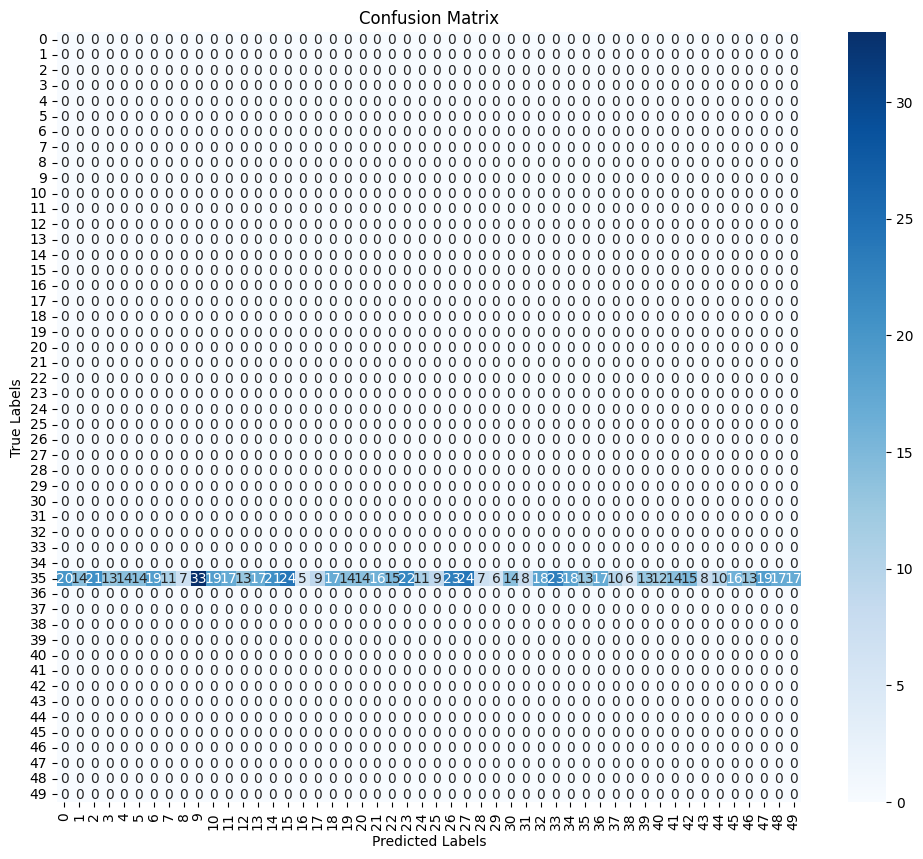

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Convert classes to strings
target_names = [str(cls) for cls in label_encoder.classes_]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(
    y_test, y_pred, target_names=target_names, zero_division=1
))


Accuracy: 0.017333333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       0.00      1.00      0.00         0
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.00      1.00      0.00         0
           5       0.00      1.00      0.00         0
           6       0.00      1.00      0.00         0
           7       0.00      1.00      0.00         0
           8       0.00      1.00      0.00         0
           9       0.00      1.00      0.00         0
          10       0.00      1.00      0.00         0
          11       0.00      1.00      0.00         0
          12       0.00      1.00      0.00         0
          13       0.00      1.00      0.00         0
          14       0.00      1.00      0.00         0
          15       0.00      1.00      0.00         0
          16       0.00   

#Monkey  species dataset

In [ ]:
train_path = '/content/drive/MyDrive/monkey_species/training/training/'
val_path = '/content/drive/MyDrive/monkey_species/validation/validation/'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image generator for loading and preprocessing images
datagen = ImageDataGenerator(rescale=1.0/255)  # Normalize pixel values (0-255 to 0-1)

print("train")
# Load training data
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(64, 64),  # Resize all images to 64x64
    batch_size=32,         # Number of images per batch
    class_mode= 'categorical'  # Multiclass classification
)

print("val")
# Load validation data
val_generator = datagen.flow_from_directory(
    val_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

# Class labels
print("Classes:", train_generator.class_indices)  # Maps folder names to class indices


train
Found 1108 images belonging to 10 classes.
val
Found 272 images belonging to 10 classes.
Classes: {'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}


####Data Cleaning/Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augment training data
augment_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift horizontally
    height_shift_range=0.2,  # Randomly shift vertically
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Randomly zoom
    horizontal_flip=True,  # Randomly flip images
    fill_mode='nearest'  # Fill empty pixels
)

train_generator = augment_datagen.flow_from_directory(
    train_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

# Validation data generator
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)


Found 1108 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [19]:
import os
import cv2
import numpy as np
import random
from skimage.feature import hog

def retrieve_images_and_labels(directory, img_size=(128, 128)):
    X = []
    y = []
    labels_map = {'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}

    for folder in os.listdir(directory):
        folder_path_full = os.path.join(directory, folder)
        for file in os.listdir(folder_path_full):
            file_path = os.path.join(folder_path_full, file)
            try:
                # Read and preprocess the image
                img = cv2.imread(file_path)
                img = cv2.resize(img, img_size)
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # Extract HOG features
                hog_features = hog(
                    img_gray,
                    orientations=9,
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2),
                    block_norm='L2-Hys',
                    visualize=False
                )
                X.append(hog_features)
                y.append(labels_map[folder])
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

    # Shuffle and return as NumPy arrays
    combined = list(zip(X, y))
    random.shuffle(combined)
    X[:], y[:] = zip(*combined)
    return np.array(X), np.array(y)


In [20]:
# Load training data
X_train_hog, y_train_hog = retrieve_images_and_labels(train_path, img_size=(128, 128))

# Load validation data
X_val_hog, y_val_hog = retrieve_images_and_labels(val_path, img_size=(128, 128))

print("Training features shape:", X_train_hog.shape)
print("Training labels shape:", y_train_hog.shape)


Training features shape: (1108, 8100)
Training labels shape: (1108,)


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train logistic regression
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial')
log_reg.fit(X_train_hog, y_train_hog)

# Predict on validation data
y_pred = log_reg.predict(X_val_hog)

# Evaluate
print("Accuracy:", accuracy_score(y_val_hog, y_pred))
print("Classification Report:\n", classification_report(y_val_hog, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.41911764705882354
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.35      0.40        26
           1       0.58      0.64      0.61        28
           2       0.34      0.44      0.39        27
           3       0.32      0.33      0.33        30
           4       0.56      0.54      0.55        26
           5       0.35      0.32      0.33        28
           6       0.27      0.23      0.25        26
           7       0.46      0.46      0.46        28
           8       0.44      0.56      0.49        27
           9       0.38      0.31      0.34        26

    accuracy                           0.42       272
   macro avg       0.42      0.42      0.42       272
weighted avg       0.42      0.42      0.42       272

